In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [3]:
# hyperparameters
# threshold step size for the ROC curve
step_size = 0.0001
# regression penalty type
penalty = 'l2'
# offset to prevent dividing by 0
eps = 10**-8

In [4]:
# load data
train = pd.read_csv("data/random_train0314.csv")
test = pd.read_csv("data/random_test0314.csv")
val = pd.read_csv("data/random_val0314.csv")

print len(train.columns), "columns"
print train.dtypes

32 columns
BorrCity                              object
BorrState                             object
BorrZip                               object
CDC_City                              object
CDC_State                             object
CDC_Zip                               object
ThirdPartyLender_City                 object
ThirdPartyLender_State                object
GrossApproval                        float64
ApprovalDate                          object
ApprovalFiscalYear                     int64
DeliveryMethod                        object
subpgmdesc                            object
TermInMonths                           int64
ProjectCounty                         object
ProjectState                          object
BusinessType                          object
LoanStatus                            object
ChargeOffDate                         object
GrossChargeOffAmount                 float64
SP500_Yearly_Return                  float64
CPI                                  float64

In [5]:
m_train = float(len(train))
m_test = float(len(test))
m_val = float(len(val))
print m_train, m_test, m_val

43844.0 5481.0 5481.0


In [6]:
# Compute some statistics
print 'Train set:'
chargeoff_count = (train.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_train

print '\n', 'Test set:'
chargeoff_count = (test.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_test

print '\n', 'Validation set:'
chargeoff_count = (val.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_val

Train set:
Chargeoffs: 7177
Percentage of loans that defaulted: 0.163694006021

Test set:
Chargeoffs: 848
Percentage of loans that defaulted: 0.154716292647

Validation set:
Chargeoffs: 957
Percentage of loans that defaulted: 0.174603174603


In [7]:
# remove variables we don't want
c = train.columns.tolist()
dropped_columns = ['LoanStatus', 'ChargeOffDate', 'GrossChargeOffAmount', 'BorrZip', 'CDC_Zip', 'BorrCity',
                   'CDC_City', 'ThirdPartyLender_City', 'ProjectCounty', 'ApprovalDate', 'Yearly_Unemployment_Rate']
for col in dropped_columns:
    c.remove(col)
print(len(c)), "covariates"
print c

22 covariates
['BorrState', 'CDC_State', 'ThirdPartyLender_State', 'GrossApproval', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'ProjectState', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics']


In [8]:
# seperate data into covariates and targets
x_train = train[c]
x_test = test[c]
x_val = val[c]

y_train = (train['LoanStatus'].values == "CHGOFF")*1
y_test = (test['LoanStatus'].values == "CHGOFF")*1
y_val = (val['LoanStatus'].values == "CHGOFF")*1

print x_train.shape
print y_train.shape
print x_train.dtypes

(43844, 22)
(43844,)
BorrState                             object
CDC_State                             object
ThirdPartyLender_State                object
GrossApproval                        float64
ApprovalFiscalYear                     int64
DeliveryMethod                        object
subpgmdesc                            object
TermInMonths                           int64
ProjectState                          object
BusinessType                          object
SP500_Yearly_Return                  float64
CPI                                  float64
Yearly_Unemployment_Rate             float64
Log_GrossApproval_Norm               float64
Log_Yearly_Unemployment_Rate_Norm    float64
Log_HPI_Norm                         float64
ThirdPartyDollars_Norm               float64
TermMultipleYear                        bool
RepeatBorrower                         int64
BankStateneqBorrowerState               bool
ProjectStateneqBorrowerState            bool
2DigitNaics                       

In [9]:
# estimate how many covariates we add by the expanding categorical columns
numerics = x_train.select_dtypes(include=[np.number,'bool'])
cats = x_train.drop(columns=numerics.columns)

uniques = np.unique(cats.values)

print "approx. number of covariate levels:", len(uniques)
print cats.dtypes

approx. number of covariate levels: 98
BorrState                 object
CDC_State                 object
ThirdPartyLender_State    object
DeliveryMethod            object
subpgmdesc                object
ProjectState              object
BusinessType              object
2DigitNaics               object
dtype: object


In [10]:
# convert categorical variables to dummy variables
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_val = pd.get_dummies(x_val)

print x_train.shape

(43844, 275)


In [11]:
# make sure the data sets all have the same levels
def add_missing_columns(d1, d2):
    missing_cols_2 = (set(d1.columns) - set(d2.columns))
    missing_cols_1 = (set(d2.columns) - set(d1.columns))
    for c in missing_cols_2:
        d2[c] = 0
    for c in missing_cols_1:
        d1[c] = 0
    return d1, d2

print 'before fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

x_train, x_test = add_missing_columns(x_train, x_test)
x_train, x_val = add_missing_columns(x_train, x_val)
x_test, x_val = add_missing_columns(x_test, x_val)
print 'after fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

before fixing columns: 
(43844, 275)
(5481, 264)
(5481, 265)
after fixing columns: 
(43844, 277)
(5481, 277)
(5481, 277)


In [12]:
# find best regularization factor and stopping time
def lr_model(x, y, C = 1, penalty = 'l2', tol = 10**-4):
    lr = LogisticRegression(solver='liblinear', multi_class= 'ovr', C=C,
                        penalty = penalty, fit_intercept=True, max_iter=200, tol = tol)
    lr.fit(x, y)
    return lr

def calc_auc(x, y, C = 1, penalty = 'l2', tol = 10**-4):
    lr = lr_model(x_train, y_train, C = C, penalty = penalty, tol = tol)
    
    y_probs = lr.predict_proba(x)
    fprs, tprs  = [], [] 
    for threshold in np.arange(step_size,1,step_size):
        y_preds = y_probs[:,1] > threshold
        fprs.append(np.sum((y == 0) * (y_preds == 1)) / (np.sum(y == 0, dtype=float) + eps))
        tprs.append(np.sum((y == 1) * (y_preds == 1)) / (np.sum(y == 1, dtype=float) + eps))

    i_prev = 0.
    auc = 0
    for i, j in zip(sorted(fprs), sorted(tprs)):
        auc += (i - i_prev)*j
        i_prev = i
    return auc

C_range = [2**i for i in range(-5,5)]
tol_range = [10**i for i in range(-8, -1)]
auc_results = {}
for C in C_range:
    for tol in tol_range:
        auc_results[calc_auc(x_val, y_val, C = C, tol = tol)] = (C, tol)
opt_auc = np.max(auc_results.keys())
opt_setting = auc_results[opt_auc]

print opt_setting, ":", opt_auc

(0.03125, 1e-07) : 0.7577646953294151


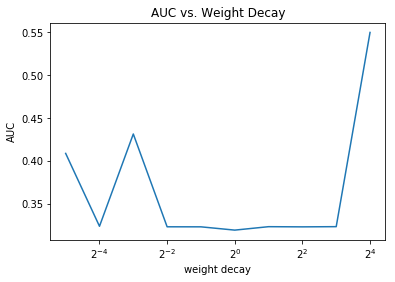

In [13]:
# plot AUC curves
auc_C_avg = np.zeros(len(C_range))
auc_tol_avg = np.zeros(len(tol_range))
for auc, (C, tol) in auc_results.items():
    auc_C_avg[C_range.index(C)] += auc
    auc_tol_avg[tol_range.index(tol)] += auc
auc_C_avg = auc_C_avg / len(tol_range)
auc_tol_avg = auc_tol_avg / len(C_range)

plt.title("AUC vs. Weight Decay")
plt.ylabel("AUC")
plt.xlabel("weight decay")

plt.xscale('log', basex = 2)
plt.plot(C_range, auc_C_avg)
plt.show()

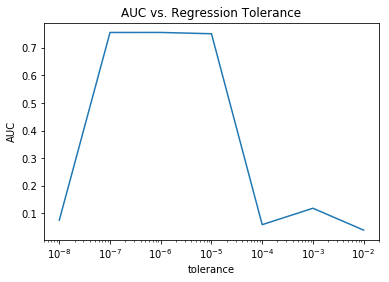

In [14]:
plt.title("AUC vs. Regression Tolerance")
plt.ylabel("AUC")
plt.xlabel("tolerance")

plt.xscale('log', basex = 10)
plt.plot(tol_range, auc_tol_avg)
plt.show()

In [15]:
# fit model and generate outputs
C_opt, tol_opt = opt_setting
lr = lr_model(x_train, y_train, C = C_opt, penalty = penalty, tol = tol_opt)

y_probs_train = lr.predict_proba(x_train)
y_probs_val = lr.predict_proba(x_val)
print y_probs_val[:5]

[[0.89296906 0.10703094]
 [0.90635526 0.09364474]
 [0.6062327  0.3937673 ]
 [0.30073188 0.69926812]
 [0.95647411 0.04352589]]


In [16]:
# calculate some statistics
y_preds_val = y_probs_val[:,1] > 0.2
print y_preds_val[:5].reshape(5,1)
print "\n", "validation accuracy", np.sum(y_preds_val == y_val, dtype=float) / m_val
print "false positive rate",  np.sum((y_val == 0) * (y_preds_val == 1)) / (np.sum(y_val == 0, dtype=float) + eps)
print "true positive rate", np.sum((y_val == 1) * (y_preds_val == 1)) / (np.sum(y_val == 1, dtype=float) + eps)

[[False]
 [False]
 [ True]
 [ True]
 [False]]

validation accuracy 0.6569968983762087
false positive rate 0.3627320954899144
true positive rate 0.750261233012014


In [17]:
# generate ROC curve
train_fprs, train_tprs, val_fprs, val_tprs  = [], [], [], []
for threshold in np.arange(step_size,1,step_size):
    y_preds_val = y_probs_val[:,1] > threshold
    val_fprs.append(np.sum((y_val == 0) * (y_preds_val == 1)) / (np.sum(y_val == 0) + eps))
    val_tprs.append(np.sum((y_val == 1) * (y_preds_val == 1)) / (np.sum(y_val == 1) + eps))
    
    y_preds_train = y_probs_train[:,1] > threshold
    train_fprs.append(np.sum((y_train == 0) * (y_preds_train == 1)) / (np.sum(y_train == 0) + eps))
    train_tprs.append(np.sum((y_train == 1) * (y_preds_train == 1)) / (np.sum(y_train == 1) + eps))
print val_fprs[:4]
print val_tprs[:4]

[0.9999999999977895, 0.9999999999977895, 0.9999999999977895, 0.9999999999977895]
[0.9999999999895507, 0.9999999999895507, 0.9999999999895507, 0.9999999999895507]


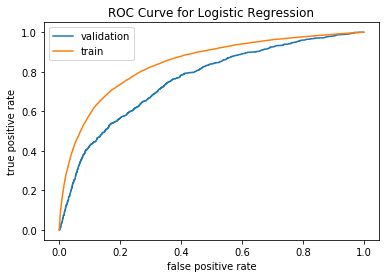

In [18]:
# plot ROC curve
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")

valplt, = plt.plot(val_fprs,val_tprs,label='validation')
trainplt, = plt.plot(train_fprs,train_tprs,label='train')
plt.legend(handles = [valplt, trainplt])

plt.show()

In [19]:
auc = 0
x_prev = 0
for x, y in zip(sorted(val_fprs), sorted(val_tprs)):
    auc += (x - x_prev)*y
    x_prev = x
print auc

0.7577646953294151


In [20]:
# save ROC curve
with open("logistic_roc.csv", "w") as file:
    file.write("threshold,fpr,tpr\n")
    for i, (fpr, tpr) in enumerate(zip(val_fprs, val_tprs), 1):
        file.write(str(step_size * i) + "," + str(fpr) + "," + str(tpr) + "\n")
print "done"

done


In [21]:
# find best threshold
senses = np.array(val_tprs, dtype=float) + eps
specs = 1 - np.array(val_fprs, dtype=float) + eps
# h_mean = 2. / (1 / senses + 1 / specs)
p = np.sum(y_val == 1) / float(len(y_val))
h_mean = 2. / (1 / ((1 - p) * senses) + 1 / (p * specs))
opt_index = np.argmax(h_mean)
opt_threshold = opt_index*step_size

print "best threshold: " , opt_threshold
print "highest sensitivity: ", val_tprs[opt_index]
print "highest specificity: ", 1 - val_fprs[opt_index]

best threshold:  0.3962
highest sensitivity:  0.49216300939924595
highest specificity:  0.8583112290011974


In [22]:
# make predictions
y_probs_train = lr.predict_proba(x_train)[:,1]
y_preds_train = y_probs_train > opt_threshold

y_probs_test = lr.predict_proba(x_test)[:,1]
y_preds_test = y_probs_test > opt_threshold

print y_probs_test[:5]
print y_preds_test[:5]

[0.18455923 0.16351092 0.2397592  0.05453853 0.44107269]
[False False False False  True]


In [23]:
# training set statistics
print 'Training set'
print 'predicted proportion of defaults: ', np.sum(y_preds_train == 1) / m_train
print 'accuracy: ', np.sum(y_preds_train == y_train) / m_train
print 'auc:', calc_auc(x_train, y_train, C = C_opt, penalty = penalty, tol = tol_opt)

# test set statistics
print '\nTest set'
print 'predicted proportion of defaults: ', np.sum(y_preds_test == 1) / m_test
print 'accuracy: ', np.sum(y_preds_test == y_test) / m_test
print 'sensivity:', np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_test == 1) + eps)
print 'specificity:', 1 - np.sum((y_test == 0) * (y_preds_test == 1)) / (np.sum(y_test == 0) + eps)
print 'auc:', calc_auc(x_test, y_test, C = C_opt, penalty = penalty, tol = tol_opt)

Training set
predicted proportion of defaults:  0.13379253717726486
accuracy:  0.861075631785421
auc: 0.8428325129389924

Test set
predicted proportion of defaults:  0.2435686918445539
accuracy:  0.7633643495712461
sensivity: 0.5224056603711981
specificity: 0.8074681631776226
auc: 0.7408503496143757


In [24]:
# calculate F1 score
precision = np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_preds_test == 1) + eps)
recall = np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_test == 1) + eps)
F1 = 2/(1 / (precision + eps) + 1 / (recall + eps))
print "precision: ", round(precision,6), "\trecall:", round(recall,6), "\tF1 score:", round(F1,6)

precision:  0.331835 	recall: 0.522406 	F1 score: 0.405864


In [25]:
# likelihood estimation
def log_likelihood(probs, y):
    return np.sum(np.log(probs[np.arange(len(probs)),y*1]))

full_ll = log_likelihood(lr.predict_proba(x_train), y_train)

ll_ratio_test = []
for column in x_train.columns:
    x_temp = x_train.copy()
    x_temp[column] = 0
    temp_ll = log_likelihood(lr.predict_proba(x_temp), y_train)
    ll_ratio_test.append((column,2*(full_ll - temp_ll)))
    
ll_ratio_test = sorted(ll_ratio_test, key=lambda t: (-t[1], t[0]))
print ll_ratio_test[:3]

[('ApprovalFiscalYear', 36920.5968964678), ('CPI', 9523.626073146559), ('Log_HPI_Norm', 5348.983500628696)]


In [26]:
for i in range(15):
    print ll_ratio_test[i]
print ""
for i in range(-15,0):
    print ll_ratio_test[i]

('ApprovalFiscalYear', 36920.5968964678)
('CPI', 9523.626073146559)
('Log_HPI_Norm', 5348.983500628696)
('ThirdPartyLender_State_MISSING', 1202.94565976812)
('BorrState_CA', 558.4068838097301)
('ProjectState_CA', 517.3811701389386)
('2DigitNaics_72', 318.96295047353124)
('SP500_Yearly_Return', 219.99565615836036)
('Yearly_Unemployment_Rate', 212.66201169505075)
('CDC_State_CA', 163.2735138730386)
('2DigitNaics_62', 99.63882333517904)
('Log_Yearly_Unemployment_Rate_Norm', 86.05743343308131)
('TermInMonths', 82.60923153084877)
('2DigitNaics_54', 78.59494612960043)
('2DigitNaics_71', 65.97070907693706)

('ProjectState_PW', 0.007873467347963015)
('2DigitNaics_55', 0.006530766870127991)
('2DigitNaics_92', 0.004703094786236761)
('subpgmdesc_Sec. 504 - Delta loans, funded 9/26/95', 0.0046138376637827605)
('ThirdPartyLender_State_GU', 0.0032863174710655585)
('ThirdPartyLender_State_AB', 0.0029998708523635287)
('2DigitNaics_45', 0.002361404254770605)
('2DigitNaics_99', 0.0011774118211178575)
('